In [7]:
!pip install torch # framework
!pip install --upgrade reedsolo

     |████████████████████████████████| 276kB 6.9MB/s 
  Created wheel for reedsolo: filename=reedsolo-1.5.1-cp36-cp36m-linux_x86_64.whl size=710220 sha256=ba95b70387dc3bbf68f055db1804791ffedadd86b21e353ac41ed455f8479345
  Stored in directory: /root/.cache/pip/wheels/41/de/37/88251b06c35aafa0463c054639defdcecfc10b1c5b5c06fbe9
Successfully built reedsolo


In [4]:
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [0]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
from torch.nn.functional import binary_cross_entropy_with_logits, mse_loss
from torchvision import datasets, transforms
from IPython.display import clear_output
import torchvision
from torch.optim import Adam
from tqdm import tqdm_notebook
import torch
import os
import gc
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
PATH='/content/drive/My Drive/results/model/EN_DE_-0.009_2020-03-04_11:21:33.dat'

In [0]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

# -*- coding: utf-8 -*-

import zlib
from math import exp

import torch
from reedsolo import RSCodec
from torch.nn.functional import conv2d

rs = RSCodec(250)


def text_to_bits(text):
    """Convert text to a list of ints in {0, 1}"""
    return bytearray_to_bits(text_to_bytearray(text))


def bits_to_text(bits):
    """Convert a list of ints in {0, 1} to text"""
    return bytearray_to_text(bits_to_bytearray(bits))


def bytearray_to_bits(x):
    """Convert bytearray to a list of bits"""
    result = []
    for i in x:
        bits = bin(i)[2:]
        bits = '00000000'[len(bits):] + bits
        result.extend([int(b) for b in bits])

    return result


def bits_to_bytearray(bits):
    """Convert a list of bits to a bytearray"""
    ints = []
    for b in range(len(bits) // 8):
        byte = bits[b * 8:(b + 1) * 8]
        ints.append(int(''.join([str(bit) for bit in byte]), 2))

    return bytearray(ints)


def text_to_bytearray(text):
    """Compress and add error correction"""
    assert isinstance(text, str), "expected a string"
    x = zlib.compress(text.encode("utf-8"))
    x = rs.encode(bytearray(x))

    return x


def bytearray_to_text(x):
    """Apply error correction and decompress"""
    try:
        text = rs.decode(x)
        text = zlib.decompress(text)
        return text.decode("utf-8")
    except BaseException:
        return False

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)


In [0]:
import torch
from torch import nn
import numpy


class BasicEncoder(nn.Module):
    """
    The BasicEncoder module takes an cover image and a data tensor and combines
    them into a steganographic image.

    """

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(3, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size + self.data_depth, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size, 3),
        )
        return self.conv1, self.conv2, self.conv3, self.conv4

    def __init__(self, data_depth, hidden_size):
        super().__init__()
        self.data_depth = data_depth
        self.hidden_size = hidden_size
        self._models = self._build_models()

    def forward(self, image, data):
        x = self._models[0](image)
        x_1 = self._models[1](torch.cat([x] + [data], dim=1))
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3


class ResidualEncoder(BasicEncoder):

    def forward(self, image, data):
        return image + super().forward(self, image, data)


class DenseEncoder(ResidualEncoder):

    def _build_models(self):
        self.conv1 = super()._models[0]
        self.conv2 = super()._models[1]
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size * 2 +
                         self.data_depth, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size * 3 + self.data_depth, 3)
        )

        return self.conv1, self.conv2, self.conv3, self.conv4

    def forward(self, image, data):
        x = self._models[0](image)
        x_list = [x]
        x_1 = self._models[1](torch.cat(x_list+[data], dim=1))
        x_list.append(x_1)
        x_2 = self._models[2](torch.cat(x_list+[data], dim=1))
        x_list.append(x_2)
        x_3 = self._models[3](torch.cat(x_list+[data], dim=1))
        x_list.append(x_3)
        return image + x_3


In [0]:
import torch
from torch import nn


class BasicDecoder(nn.Module):
    """
    The BasicDecoder module takes an steganographic image and attempts to decode
    the embedded data tensor.

    Input: (N, 3, H, W)
    Output: (N, D, H, W)
    """

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(3, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size, self.data_depth)
        )

        return self.conv1, self.conv2, self.conv3, self.conv4

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3

    def __init__(self, data_depth, hidden_size):
        super().__init__()
        self.data_depth = data_depth
        self.hidden_size = hidden_size
        self._models = self._build_models()


class DenseDecoder(BasicDecoder):

    def _build_models(self):
        self.conv1 = super()._models[0]
        self.conv2 = super()._models[1]
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size * 2, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size)
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size * 3, self.data_depth)
        )

        return self.conv1, self.conv2, self.conv3, self.conv4

    def forward(self, image):
        x = self._models[0](image)
        x_list = [x]
        x_1 = self._models[1](torch.cat(x_list, dim=1))
        x_list.append(x_1)
        x_2 = self._models[2](torch.cat(x_list, dim=1))
        x_list.append(x_2)
        x_3 = self._models[3](torch.cat(x_list, dim=1))
        x_list.append(x_3)
        return x_3


In [0]:
import torch
from torch import nn


class BasicCritic(nn.Module):
    """
    The BasicCritic module takes an image and predicts whether it is a cover
    image or a steganographic image (N, 1).

    Input: (N, 3, H, W)
    Output: (N, 1)
    """

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3
        )

    def _build_models(self):

        self.conv1 = nn.Sequential(
            self._conv2d(3, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )  
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size, 1)
        )         

        return self.conv1,self.conv2,self.conv3,self.conv4

    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self._models = self._build_models()

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return torch.mean(x_3.view(x_3.size(0), -1), dim=1)
        

In [0]:
def plot(name, train_epoch, values, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('validation_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('results/plots/%s_%.3f_%d_%s.png' %
                        (name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [0]:
def test(encoder,decoder, cover, payload):
  %matplotlib inline
  generated = encoder.forward(cover, payload)
  result = decoder.forward(cover)
  f, ax = plt.subplots(1, 2)
  cover=np.transpose(np.squeeze(cover.cpu()), (1, 2, 0))
  ax[0].imshow(cover)
  ax[0].axis('off')
  generated=np.transpose(np.squeeze((generated.cpu()).detach().numpy()), (1, 2, 0))
  ax[1].imshow(generated)
  ax[1].axis('off')
  now = datetime.datetime.now()
  print(result)
  #get_fig.savefig('results/samples/%s_%.3f_%d_%s.png' %
              #(name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [79]:
if __name__ == '__main__':
    for func in [
            lambda: os.mkdir(os.path.join('.', 'results')),
            lambda: os.mkdir(os.path.join('.', 'results/model')),
            lambda: os.mkdir(os.path.join('.', 'results/plots'))]:  # create directories
        try:
            func()
        except Exception as error:
            print(error)
            continue
    data_dir = 'div2k'
    epochs = 32
    data_depth = 2
    hidden_size = 32
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    METRIC_FIELDS = [
        'val.encoder_mse',
        'val.decoder_loss',
        'val.decoder_acc',
        'val.cover_score',
        'val.generated_score',
        'val.ssim',
        'val.psnr',
        'val.bpp',
        'train.encoder_mse',
        'train.decoder_loss',
        'train.decoder_acc',
        'train.cover_score',
        'train.generated_score',
    ]

    mu = [.5, .5, .5]
    sigma = [.5, .5, .5]

    transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(
                                        360, pad_if_needed=True),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])

    train_set = datasets.ImageFolder(os.path.join(
        data_dir, "train/"), transform=transform)
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=4, shuffle=True)

    valid_set = datasets.ImageFolder(os.path.join(
        data_dir, "val/"), transform=transform)
    valid_loader = torch.utils.data.DataLoader(
        valid_set, batch_size=4, shuffle=False)

    encoder = BasicEncoder(data_depth, hidden_size).to(device)
    decoder = BasicDecoder(data_depth, hidden_size).to(device)
    critic = BasicCritic(hidden_size).to(device)
    cr_optimizer = Adam(critic.parameters(), lr=1e-4)
    # Why add encoder parameters too?
    en_de_optimizer = Adam(list(decoder.parameters()) +
                           list(encoder.parameters()), lr=1e-4)

    metrics = {field: list() for field in METRIC_FIELDS}
    for ep in range(epochs):
        for cover, _ in tqdm_notebook(train_loader):
            gc.collect()
            cover = cover.to(device)
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)
            cover_score = torch.mean(critic.forward(cover))
            generated_score = torch.mean(critic.forward(generated))

            cr_optimizer.zero_grad()
            (cover_score - generated_score).backward(retain_graph=False)
            cr_optimizer.step()

            for p in critic.parameters():
                p.data.clamp_(-0.1, 0.1)
            metrics['train.cover_score'].append(cover_score.item())
            metrics['train.generated_score'].append(generated_score.item())

        for cover, _ in tqdm_notebook(train_loader):
            gc.collect()
            cover = cover.to(device)
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)
            decoded = decoder.forward(generated)

            encoder_mse = mse_loss(generated, cover)
            decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
            decoder_acc = (decoded >= 0.0).eq(
                payload >= 0.5).sum().float() / payload.numel()
            generated_score = torch.mean(critic.forward(generated))

            en_de_optimizer.zero_grad()
            (100.0 * encoder_mse + decoder_loss +
             generated_score).backward()  # Why 100?
            en_de_optimizer.step()

            metrics['train.encoder_mse'].append(encoder_mse.item())
            metrics['train.decoder_loss'].append(decoder_loss.item())
            metrics['train.decoder_acc'].append(decoder_acc.item())

        for cover, _ in tqdm_notebook(valid_loader):
            gc.collect()
            cover = cover.to(device)
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)
            decoded = decoder.forward(generated)

            encoder_mse = mse_loss(generated, cover)
            decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
            decoder_acc = (decoded >= 0.0).eq(
                payload >= 0.5).sum().float() / payload.numel()
            generated_score = torch.mean(critic.forward(generated))
            cover_score = torch.mean(critic.forward(cover))

            metrics['val.encoder_mse'].append(encoder_mse.item())
            metrics['val.decoder_loss'].append(decoder_loss.item())
            metrics['val.decoder_acc'].append(decoder_acc.item())
            metrics['val.cover_score'].append(cover_score.item())
            metrics['val.generated_score'].append(generated_score.item())
            metrics['val.ssim'].append(
                ssim(cover, generated).item())
            metrics['val.psnr'].append(
                10 * torch.log10(4 / encoder_mse).item())
            metrics['val.bpp'].append(
                data_depth * (2 * decoder_acc.item() - 1))
    now = datetime.datetime.now()
    name = "EN_DE_%+.3f_%s.dat" % (cover_score.item(),
                                   now.strftime("%Y-%m-%d_%H:%M:%S"))
    fname = os.path.join('.', 'results/model', name)
    states = {
            'state_dict_critic': critic.state_dict(),
            'state_dict_encoder': encoder.state_dict(),
            'state_dict_decoder': decoder.state_dict(),
            'en_de_optimizer': en_de_optimizer.state_dict(),
            'cr_optimizer': cr_optimizer.state_dict(),
            'metrics': metrics,
            'train_epoch': ep,
            'date': now.strftime("%Y-%m-%d_%H:%M:%S"),
    }
    torch.save(states, fname)
    plot('encoder_mse', ep, metrics['val.encoder_mse'], True)
    plot('decoder_loss', ep, metrics['val.decoder_loss'], True)
    plot('decoder_acc', ep, metrics['val.decoder_acc'], True)
    plot('cover_score', ep, metrics['val.cover_score'], True)
    plot('generated_score', ep, metrics['val.generated_score'], True)
    plot('ssim', ep, metrics['val.ssim'], True)
    plot('psnr', ep, metrics['val.psnr'], True)
    plot('bpp', ep, metrics['val.bpp'], True)
    cover=datasets.RandomSampler(valid_set,num_samples=1)
    cover = cover.to(device)
    N, _, H, W = cover.size()
    payload = torch.zeros((N, data_depth, H, W),
                          device=device).random_(0, 2)
    test(encoder,decoder,cover,payload)


                

[Errno 17] File exists: './results'
[Errno 17] File exists: './results/model'
[Errno 17] File exists: './results/plots'


KeyboardInterrupt: ignored

In [23]:
for func in [
          lambda: os.mkdir(os.path.join('.', 'results')),
          lambda: os.mkdir(os.path.join('.', 'results/model')),
          lambda: os.mkdir(os.path.join('.', 'results/plots'))]:  # create directories
      try:
          func()
      except Exception as error:
          print(error)
          continue
data_dir = 'div2k'
epochs = 32
data_depth = 2
hidden_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

METRIC_FIELDS = [
        'val.encoder_mse',
        'val.decoder_loss',
        'val.decoder_acc',
        'val.cover_score',
        'val.generated_score',
        'val.ssim',
        'val.psnr',
        'val.bpp',
        'train.encoder_mse',
        'train.decoder_loss',
        'train.decoder_acc',
        'train.cover_score',
        'train.generated_score',
]

mu = [.5, .5, .5]
sigma = [.5, .5, .5]

transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(
                                        360, pad_if_needed=True),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])

train_set = datasets.ImageFolder(os.path.join(
        data_dir, "train/"), transform=transform)
train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=4, shuffle=True)

valid_set = datasets.ImageFolder(os.path.join(
        data_dir, "val/"), transform=transform)
valid_loader = torch.utils.data.DataLoader(
        valid_set, batch_size=4, shuffle=False)

encoder = BasicEncoder(data_depth, hidden_size).to(device)
decoder = BasicDecoder(data_depth, hidden_size).to(device)
critic = BasicCritic(hidden_size).to(device)
cr_optimizer = Adam(critic.parameters(), lr=1e-4)
    # Why add encoder parameters too?
en_de_optimizer = Adam(list(decoder.parameters()) +
                           list(encoder.parameters()), lr=1e-4)

metrics = {field: list() for field in METRIC_FIELDS}
if True: # transfer learning set this variable to True
  if torch.cuda.is_available():
    checkpoint = torch.load(PATH)
  else:
    checkpoint = torch.load(PATH, map_location=lambda storage, loc: storage)
              
  critic.load_state_dict(checkpoint['state_dict_critic'])
  encoder.load_state_dict(checkpoint['state_dict_encoder'])
  decoder.load_state_dict(checkpoint['state_dict_decoder'])
  en_de_optimizer.load_state_dict(checkpoint['en_de_optimizer'])
  cr_optimizer.load_state_dict(checkpoint['cr_optimizer'])
  metrics=checkpoint['metrics']
  train_epoch=checkpoint['train_epoch']
  date=checkpoint['date']
  print('GAN loaded')

  print(critic)
  print(encoder)
  print(decoder)
  print(en_de_optimizer)
  print(cr_optimizer)
  print(date)

[Errno 17] File exists: './results'
[Errno 17] File exists: './results/model'
[Errno 17] File exists: './results/plots'
GAN loaded
BasicCritic(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)
BasicEncoder(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), str

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[-0.4937, -2.3233,  0.3212,  ...,  0.6703,  0.5256, -1.7977],
          [ 0.7317,  1.2394,  2.7884,  ...,  3.5704, -6.0072, -2.6419],
          [-0.1836,  2.9114,  1.2365,  ...,  2.7009, -0.8439,  1.2413],
          ...,
          [-2.2390,  2.2393, -3.5650,  ...,  7.9128,  7.1769, -4.6098],
          [-0.9595, -0.4240, -1.4486,  ..., -0.5461, -1.3247, -1.0333],
          [ 1.5923, -0.5834, -0.2301,  ..., -2.7084, -4.6197, -0.5402]],

         [[-1.1316,  2.1936,  0.1242,  ...,  0.6152, -1.5943, -0.2288],
          [ 0.3935, -0.9258, -1.1168,  ..., -1.6483,  1.9041, -0.9259],
          [ 0.2033, -3.2483,  0.5940,  ..., -4.1055, 10.0220,  2.3432],
          ...,
          [ 4.2494, -2.8050,  3.3974,  ...,  4.5246,  3.4983, -1.2209],
          [ 0.0316,  3.2262,  0.6821,  ..., -4.4865,  1.6791, -1.5374],
          [ 0.2259, -2.1203,  0.3291,  ...,  1.5441,  4.1692, -3.5341]]]],
       device='cuda:0', grad_fn=<CudnnConvolutionBackward>)


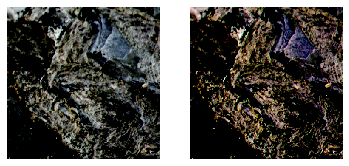

In [30]:
cover, _ = next(iter(valid_set))
_, H, W = cover.size()
cover = cover[None].to(device)
payload = torch.zeros((1, data_depth, H, W),device=device).random_(0, 2)
test(encoder,decoder,cover,payload)